In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/home/rarpin/baseball_project/data/parsed/events_extended.csv', 
                 header=None, low_memory=False)

cols = {
    0: 'game_id',
    2: 'inning',
    3: 'batting_team',
    4: 'outs',
    26: 'runner_on_1b',
    27: 'runner_on_2b',
    28: 'runner_on_3b',
    29: 'event_text',
    34: 'event_type',
}
df = df.rename(columns=cols)

# Calculate runs from destination columns
df['runs_on_play'] = sum((df[col] >= 4).astype(int) for col in [58, 59, 60, 61])

print(df.shape)
print("HR runs:", df[df['event_type'] == 23]['runs_on_play'].value_counts().sort_index())

(568665, 162)
HR runs: runs_on_play
1    9820
2    4872
3    1900
4     379
Name: count, dtype: int64


In [3]:
df['on_1b'] = df['runner_on_1b'].notna().astype(int)
df['on_2b'] = df['runner_on_2b'].notna().astype(int)
df['on_3b'] = df['runner_on_3b'].notna().astype(int)

df['base_state'] = df['on_1b'].astype(str) + df['on_2b'].astype(str) + df['on_3b'].astype(str)

print(df['base_state'].value_counts())

base_state
000    310843
100    112220
010     48935
110     38690
101     17768
001     14509
111     12858
011     12842
Name: count, dtype: int64


In [4]:
df['half_inning'] = df['game_id'] + '_' + df['inning'].astype(str) + '_' + df['batting_team'].astype(str)

df['runs_to_end'] = df.groupby('half_inning')['runs_on_play'].transform(lambda x: x[::-1].cumsum()[::-1])

df[['half_inning', 'outs', 'base_state', 'runs_on_play', 'runs_to_end']].head(10)

,half_inning,outs,base_state,runs_on_play,runs_to_end
0,ANA202304070_1_0,0,000,0,0
1,ANA202304070_1_0,1,000,0,0
2,ANA202304070_1_0,1,010,0,0
3,ANA202304070_1_0,2,010,0,0
4,ANA202304070_1_1,0,000,0,2
5,ANA202304070_1_1,0,100,2,2
6,ANA202304070_1_1,0,000,0,0
7,ANA202304070_1_1,1,000,0,0
8,ANA202304070_1_1,1,100,0,0
9,ANA202304070_1_1,2,100,0,0


In [19]:
df_valid = df[df['outs'] < 3].copy()

run_expectancy = df_valid.groupby(['outs', 'base_state'])['runs_to_end'].mean().reset_index()
run_expectancy.columns = ['outs', 'base_state', 'run_expectancy']

matrix = run_expectancy.pivot(index='base_state', columns='outs', values='run_expectancy')
matrix.columns = ['0 outs', '1 out', '2 outs']

# Sort rows by average run expectancy ascending
state_order = matrix.mean(axis=1).sort_values().index
matrix = matrix.loc[state_order]

print(matrix.round(3))

            0 outs  1 out  2 outs
base_state                       
000          0.500  0.267   0.102
100          0.895  0.529   0.232
010          1.125  0.681   0.324
001          1.402  0.949   0.354
110          1.505  0.944   0.461
101          1.849  1.202   0.504
011          1.959  1.387   0.569
111          2.323  1.593   0.782


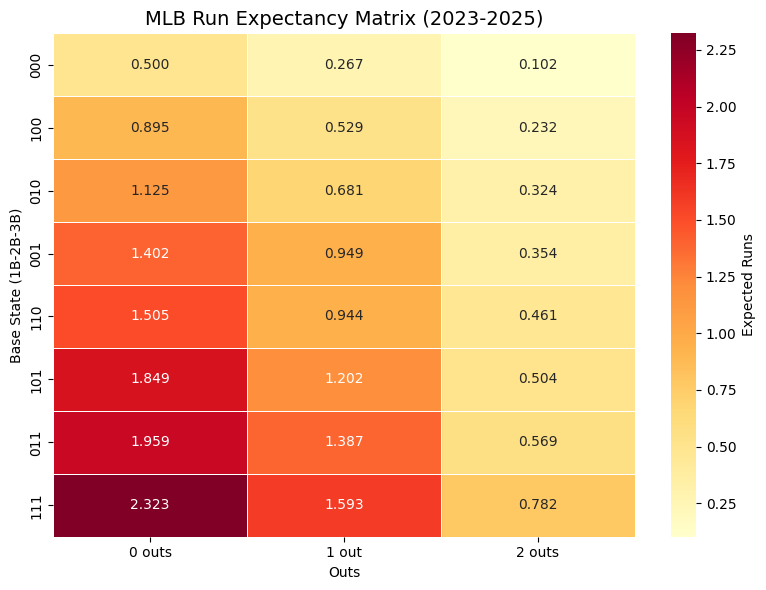

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=0.5, cbar_kws={'label': 'Expected Runs'})
plt.title('MLB Run Expectancy Matrix (2023-2025)', fontsize=14)
plt.xlabel('Outs')
plt.ylabel('Base State (1B-2B-3B)')
plt.tight_layout()
plt.show()

In [21]:
# Base state after play from extended field (col 111)
base_state_map = {
    0: '000', 1: '100', 2: '010', 3: '110',
    4: '001', 5: '101', 6: '011', 7: '111'
}

df_valid['base_state_after'] = df[111].map(base_state_map)
df_valid['outs_after'] = df_valid['outs'] + df_valid[40]

re_dict = {}
for _, row in run_expectancy.iterrows():
    re_dict[(int(row['outs']), row['base_state'])] = row['run_expectancy']

df_valid['re_before'] = df_valid.apply(lambda r: re_dict.get((r['outs'], r['base_state']), 0), axis=1)
df_valid['re_after'] = df_valid.apply(
    lambda r: re_dict.get((int(r['outs_after']), r['base_state_after']), 0) 
    if r['outs_after'] < 3 else 0, axis=1)

df_valid['run_value'] = df_valid['re_after'] - df_valid['re_before'] + df_valid['runs_on_play']

In [23]:
event_types = {
    2: 'Field Out',
    3: 'Strikeout',
    4: 'Stolen Base',
    5: 'Def. Indifference',
    6: 'Caught Stealing',
    9: 'Wild Pitch',
    14: 'Walk',
    15: 'Int. Walk',
    16: 'Hit by Pitch',
    18: 'Error',
    19: "Fielder's Choice",
    20: 'Single',
    21: 'Double',
    22: 'Triple',
    23: 'Home Run',
}

df_valid['event_name'] = df_valid['event_type'].map(event_types)
event_values = df_valid.groupby('event_name')['run_value'].mean().sort_values(ascending=False)
print(event_values.round(3))

event_name
Home Run             1.389
Triple               1.051
Double               0.754
Single               0.469
Error                0.442
Hit by Pitch         0.350
Walk                 0.324
Wild Pitch           0.251
Int. Walk            0.215
Stolen Base          0.164
Fielder's Choice     0.112
Def. Indifference    0.099
Field Out           -0.270
Strikeout           -0.273
Caught Stealing     -0.428
Name: run_value, dtype: float64


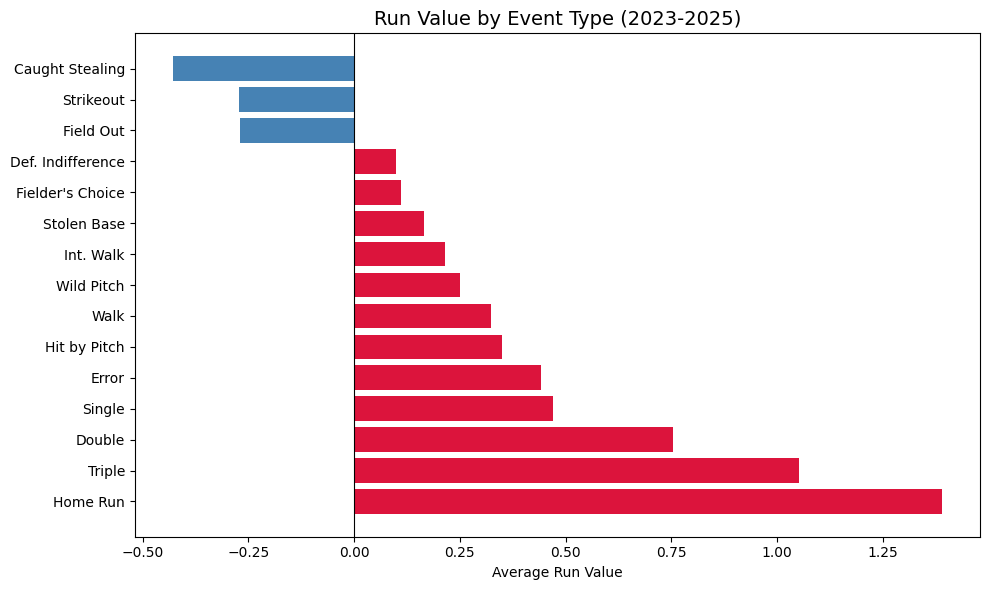

In [24]:
ev_plot = event_values.dropna()

plt.figure(figsize=(10, 6))
colors = ['crimson' if v > 0 else 'steelblue' for v in ev_plot.values]
plt.barh(ev_plot.index, ev_plot.values, color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Run Value by Event Type (2023-2025)', fontsize=14)
plt.xlabel('Average Run Value')
plt.tight_layout()
plt.show()

In [25]:
# Stolen base break-even analysis
# If you steal 2nd: success = gain a base, fail = lose runner + out

steal_situations = [
    ('100', '010', '0 outs', 0),
    ('100', '010', '1 out', 1),
    ('100', '010', '2 outs', 2),
]

print("Stolen Base 2nd - Break-even Success Rate")
print("-" * 45)
for base_before, base_after_success, out_label, outs in steal_situations:
    re_before = re_dict[(outs, base_before)]
    re_success = re_dict[(outs, base_after_success)]
    re_fail = re_dict[(min(outs+1, 2), '000')] if outs < 2 else 0
    
    # break_even: p * re_success + (1-p) * re_fail = re_before
    # solve for p
    break_even = (re_before - re_fail) / (re_success - re_fail)
    print(f"{out_label}: must succeed {break_even:.1%} of the time")

Stolen Base 2nd - Break-even Success Rate
---------------------------------------------
0 outs: must succeed 73.3% of the time
1 out: must succeed 73.8% of the time
2 outs: must succeed 71.5% of the time


In [26]:
# Stealing 3rd break-even
print("Stolen Base 3rd - Break-even Success Rate")
print("-" * 45)
steal_3rd = [
    ('010', '001', 0),
    ('010', '001', 1),
    ('010', '001', 2),
]

for base_before, base_after_success, outs in steal_3rd:
    re_before = re_dict[(outs, base_before)]
    re_success = re_dict[(outs, base_after_success)]
    re_fail = re_dict[(min(outs+1, 2), '000')] if outs < 2 else 0
    break_even = (re_before - re_fail) / (re_success - re_fail)
    print(f"{outs} outs: must succeed {break_even:.1%} of the time")



Stolen Base 3rd - Break-even Success Rate
---------------------------------------------
0 outs: must succeed 75.6% of the time
1 outs: must succeed 68.4% of the time
2 outs: must succeed 91.6% of the time


In [27]:
# Sacrifice Bunt - Run Expectancy Change
print("Sacrifice Bunt - Run Expectancy Change")
print("-" * 45)

bunt_situations = [
    ('100', '010', 0, 1, 'Runner on 1st, 0 outs'),
    ('010', '001', 0, 1, 'Runner on 2nd, 0 outs'),
    ('110', '011', 0, 1, 'Runners on 1st+2nd, 0 outs'),
]

for base_before, base_after, outs_before, outs_after, label in bunt_situations:
    re_before = re_dict[(outs_before, base_before)]
    re_after = re_dict[(outs_after, base_after)]
    change = re_after - re_before
    verdict = "WORTH IT" if change > 0 else "NOT WORTH IT"
    print(f"{label}: {re_before:.3f} -> {re_after:.3f} ({change:+.3f}) — {verdict}")

Sacrifice Bunt - Run Expectancy Change
---------------------------------------------
Runner on 1st, 0 outs: 0.895 -> 0.681 (-0.214) — NOT WORTH IT
Runner on 2nd, 0 outs: 1.125 -> 0.949 (-0.175) — NOT WORTH IT
Runners on 1st+2nd, 0 outs: 1.505 -> 1.387 (-0.119) — NOT WORTH IT


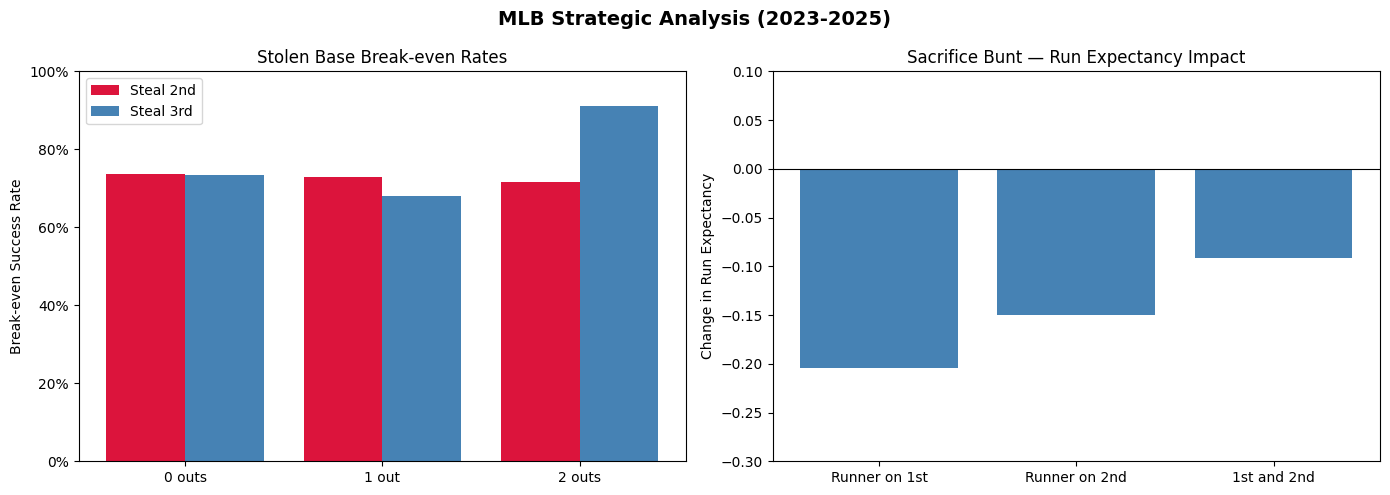

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stolen base break-even
situations = ['0 outs', '1 out', '2 outs']
sb2_rates = [0.737, 0.730, 0.717]
sb3_rates = [0.733, 0.680, 0.910]

ax1.bar(x - 0.2, sb2_rates, 0.4, label='Steal 2nd', color='crimson')
ax1.bar(x + 0.2, sb3_rates, 0.4, label='Steal 3rd', color='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(situations)
ax1.set_ylabel('Break-even Success Rate')
ax1.set_title('Stolen Base Break-even Rates')
ax1.set_ylim(0, 1)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax1.legend()

# Bunt run expectancy change
labels = ['Runner on 1st', 'Runner on 2nd', '1st and 2nd']
changes = [-0.204, -0.150, -0.091]
colors = ['steelblue'] * 3
ax2.bar(labels, changes, color=colors)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_ylabel('Change in Run Expectancy')
ax2.set_title('Sacrifice Bunt — Run Expectancy Impact')
ax2.set_ylim(-0.3, 0.1)

plt.suptitle('MLB Strategic Analysis (2023-2025)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()